# Linear Regression Analysis of Ames, Iowa Housing Data from Kaggle
by Nati Marcus

In [285]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.pipeline import Pipeline
from statsmodels.api import OLS
import statsmodels.api as sm

# Sections
1. [EDA](#EDA)
2. [Regression Functions](#Regression-Functions)
3. [Model 1](#Model-1-(MLR-with-Numerical-Features-Scaled))
4. [Model 2](#Model-2-(Using-Interaction-Terms))
5. [Model 3](#Model-3-(Adding-Polynomial-Features))
6. [Model 4](#Model-4-(Dropping-Insignficant-Poly-Features))
7. [Model 5](#Model-5-(Trying-Model-with-Dummy-Variables))
8. [Model 6](#Model-6)
9. [Test Data Prediction](#Running-Model-5-On-Test-Data)

## EDA

In [2]:
df = pd.read_csv('datasets/train.csv')

In [3]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
df.shape

(2051, 81)

In [283]:
#checking to see which columns are numerical
list(df.describe().columns)[:5]

['Id', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area']

In [161]:
#checking to see which columns have the most null values
#df.isna().sum().sort_values(ascending=False).index.to_list()

Columns that contain the most nulls (>= ~300) are: `Pool QC`,`Misc Feature`,`Alley`,`Fence`,`Fireplace Qu`, and `Lot Frontage`.

Actual Numerical Features:
1) `Lot Frontage`
2) `Lot Area`
3) `Mas Vnr Area`
4) `BsmtFin SF 1`
5) `BsmtFin SF 2`
6) `Bsmt Unf SF`
7) `Total Bsmt SF`
8) `1st Flr SF`
9) `2nd Flr SF`
10) `Low Qual Fin SF`
11) `Gr Liv Area`
12) `Bsmt Full Bath`
13) `Bsmt Half Bath`
14) `Full Bath`
15) `Half Bath`
16) `Bedroom AbvGr`
17) `Kitchen AbvGr`
18) `TotRms AbvGrd`
19) `Fireplaces`
20) `Garage Cars`
21) `Garage Area`
22) `Wood Deck SF`
23) `Open Porch SF`
24) `Enclosed Porch`
25) `3Ssn Porch`
26) `Screen Porch`
27) `Pool Area`
28) `Misc Val`

In [162]:
#df.info()

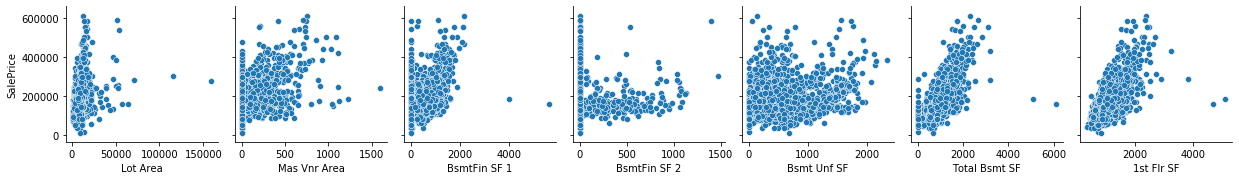

In [173]:
#creating a pairplot of 1/4 of the numerical features above (so as not to clutter the screen) to check relationship
#with SalePrice variable
sns.pairplot(data=df,x_vars = ['Lot Area','Mas Vnr Area','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF',
'Total Bsmt SF','1st Flr SF'],
             y_vars = ['SalePrice']);

Features of Interest:
`1st Flr SF`, `Total Bsmt SF`.

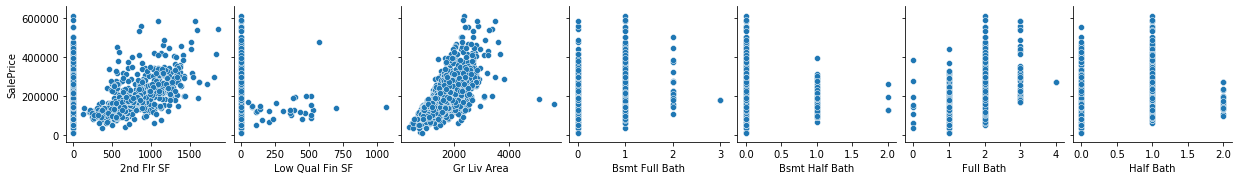

In [174]:
#pairplot for second quarter numerical features, to check their relationship with SalePrice
sns.pairplot(data=df,x_vars=['2nd Flr SF','Low Qual Fin SF','Gr Liv Area','Bsmt Full Bath',
              'Bsmt Half Bath','Full Bath','Half Bath'],
            y_vars=['SalePrice']);

Features of Interest: `2nd Flr SF`,`Gr Liv Area`,`Full Bath`

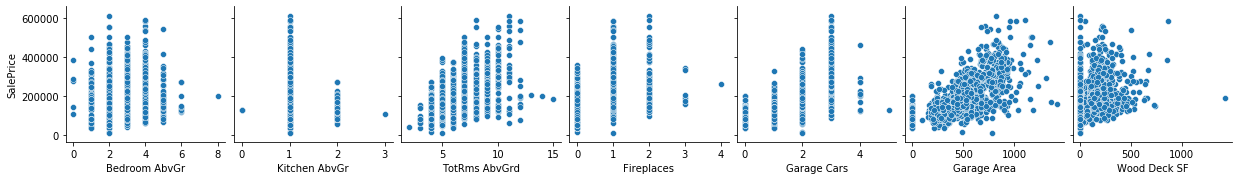

In [175]:
#pairplot for second to last quarter numerical features, to check their relationship with SalePrice
sns.pairplot(data=df,x_vars=['Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd',
        'Fireplaces','Garage Cars','Garage Area','Wood Deck SF'],
            y_vars=['SalePrice']);

Features of Interest: `TotRms AbvGrd`,`Fireplaces`,`Garage Cars`,`Garage Area`

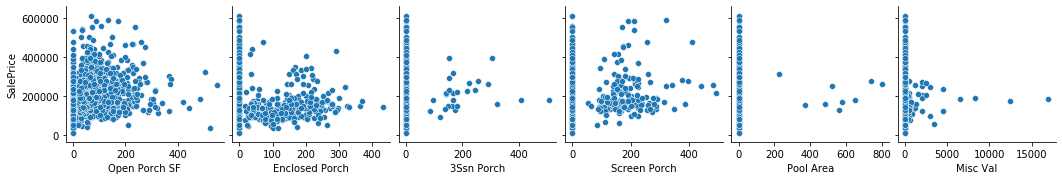

In [176]:
#pairplot for last quarter numerical features, to check their relationship with SalePrice
sns.pairplot(data=df,x_vars=['Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area','Misc Val'],
            y_vars=['SalePrice']);

Features of Interest: None

All Features of Interest for First Regression: `1st Flr SF`,`Total Bsmt SF`,`2nd Flr SF`,`Gr Liv Area`,`Full Bath`,`TotRms AbvGrd`,`Fireplaces`,`Garage Cars`,`Garage Area`

## Regression Functions

[Back to Top](#Sections)

In [316]:
#function that takes in a list of columns and returns the lower triangle of a heatmap. code references class material
def heatmap(columns,df,size=(10,6)):
    mask = np.zeros_like(df[columns].corr())
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=size)
    sns.heatmap(df[columns].corr(),annot=True,mask=mask)
    plt.xticks(rotation=65);
    return

In [70]:
'''
Main regression function that takes in features and an outcome variable, along with keyword arguments that determine
if the feature data is scaled, or if ridge/lassoCV regularization is performed on the features, and returns a
dictionary that contains train and test scores, cv train scores, and rmse for each combination of 
scaling/regularization
'''
#many references to class lesson-starter code
def regression(X,y,cv=3,scale=False,ridge=False,lasso=False):
    #section that computes regression on non-scaled, non-regularized data and returns scores
    default_dict = {}
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=32)
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    default_dict['cv_score'] = cross_val_score(lr,X_train,y_train,cv=cv).mean()
    default_dict['train_score'] = lr.score(X_train,y_train)
    default_dict['test_score'] = lr.score(X_test,y_test)
    default_dict['rmse'] = np.sqrt(mean_squared_error(y_train,lr.predict(X_train)))
    
    #section that computes regression on scaled, non-regularized data and returns scores
    scale_dict = {}
    if scale == True:
        sc = StandardScaler()
        X_train_sc = sc.fit_transform(X_train)
        X_test_sc = sc.transform(X_test)
        lr = LinearRegression()
        lr.fit(X_train_sc,y_train)
        scaled_cv_score = cross_val_score(lr,X_train_sc,y_train,cv=cv).mean()
        scale_dict['cv_score_sc'] = scaled_cv_score
        scale_dict['train_score_sc'] = lr.score(X_train_sc,y_train)
        scale_dict['test_score_sc'] = lr.score(X_test_sc,y_test)
        scale_dict['rmse_sc'] = np.sqrt(mean_squared_error(y_train,lr.predict(X_train_sc)))
        
        #section that computes regression on scaled, ridge regularized data and returns scores
        scale_ridge_dict = {}
        if ridge == True:    
            alphas = np.logspace(0,5,50)
            cv = RidgeCV(alphas = alphas, scoring='r2',cv=cv)
            ridge_cv = cv.fit(X_train,y_train)
            a = ridge_cv.alpha_
            r = Ridge(alpha=a)
            r.fit(X_train_sc,y_train)
            r_cv_score_sc = cross_val_score(r,X_train_sc,y_train).mean()
            r_train_score_sc = r.score(X_train_sc,y_train)
            r_test_score_sc = r.score(X_test_sc,y_test)
            scale_ridge_dict['rcv_best_score_sc'] = ridge_cv.best_score_
            scale_ridge_dict['r_cv_score_sc'] = r_cv_score_sc
            scale_ridge_dict['r_train_score_sc'] = r_train_score_sc
            scale_ridge_dict['r_test_score_sc'] = r_test_score_sc
            scale_ridge_dict['r_rmse_sc'] = np.sqrt(mean_squared_error(y_train,r.predict(X_train_sc)))
            scale_ridge_dict['rcv_rmse_sc'] = np.sqrt(mean_squared_error(y_train,ridge_cv.predict(X_train_sc)))
        
        #section that computes regression on scaled, lassoCV regularized data and returns scores
        scale_lasso_dict = {}
        if lasso == True:
            l_alphas = np.logspace(-3,0,100)
            lasso_cv = LassoCV(alphas=l_alphas,cv=5,max_iter=50_000)
            lasso_cv.fit(X_train_sc,y_train)
            scale_lasso_dict['lassoCV_train_score_sc'] = lasso_cv.score(X_train_sc,y_train)
            scale_lasso_dict['lassoCV_test_score_sc'] = lasso_cv.score(X_test_sc,y_test)
            scale_lasso_dict['lassoCV_rmse_sc'] = np.sqrt(mean_squared_error(y_train,lasso_cv.predict(X_train_sc)))
            
    else:
        #section that computes regression on non-scaled, ridge regularized data and returns scores
        ridge_dict = {}
        if ridge == True:    
            alphas = np.logspace(0,5,50)
            cv = RidgeCV(alphas = alphas, scoring='r2',cv=cv)
            ridge_cv = cv.fit(X_train,y_train)
            a = ridge_cv.alpha_
            r = Ridge(alpha=a)
            r.fit(X_train,y_train)
            r_cv_score = cross_val_score(r,X_train,y_train).mean()
            r_train_score = r.score(X_train,y_train)
            r_test_score = r.score(X_test,y_test)
            ridge_dict['rcv_best_score'] = ridge_cv.best_score_
            ridge_dict['r_cv_score'] = r_cv_score
            ridge_dict['r_train_score'] = r_train_score
            ridge_dict['r_test_score'] = r_test_score
            ridge_dict['r_rmse'] = np.sqrt(mean_squared_error(y_train,r.predict(X_train)))
            ridge_dict['rcv_rmse'] = np.sqrt(mean_squared_error(y_train,ridge_cv.predict(X_train)))
        
        #section that computes regression on non-scaled, lassoCV regularized data and returns scores
        lasso_dict = {}
        if lasso == True:
            l_alphas = np.logspace(-3,0,100)
            lasso_cv = LassoCV(alphas=l_alphas,cv=5,max_iter=50_000)
            lasso_cv.fit(X_train,y_train)
            lasso_dict['lassoCV_train_score'] = lasso_cv.score(X_train,y_train)
            lasso_dict['lassoCV_test_score'] = lasso_cv.score(X_test,y_test)
            lasso_dict['lassoCV_rmse'] = np.sqrt(mean_squared_error(y_train,lasso_cv.predict(X_train)))
    
    #using boolean statements to assess which scores to return based on given keyword arguments
    if scale == True and ridge == True and lasso == False:
        return scale_ridge_dict
    elif scale == True and ridge == False and lasso == False:
        return scale_dict
    elif scale == False and ridge == True and lasso == False:
        return ridge_dict
    elif scale == True and lasso == True and ridge == False:
        return scale_lasso_dict
    elif scale == False and lasso == True and ridge == False:
        return lasso_dict
    else:
        return default_dict

In [228]:
#computes and prints summary of OLS regression 
def OLS_sum(X,y,scale=False):
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=32)
    if scale == True:
        sc = StandardScaler()
        X_train_sc = sc.fit_transform(X_train)
        X_test_sc = sc.transform(X_test)
        X_train_sc = sm.add_constant(X_train_sc)
        ols = OLS(y_train,X_train_sc)
    else:
        lr = LinearRegression()
        lr.fit(X_train,y_train)
        X = sm.add_constant(X)
        ols = OLS(y_train,X_train)
    return ols.fit().summary()

## Baseline Model

[Back to Top](#Sections)

In [265]:
y_true = df['SalePrice']

In [266]:
y_pred = [df['SalePrice'].median() for price in y_true]

In [267]:
np.sqrt(sum([(y_pred[i]-y_true[i])**2 for i in range(len(y_pred))])/len(y_pred))

81478.35170750102

In [268]:
np.sqrt(mean_squared_error(y_true,y_pred))

81478.35170750102

## Model 1 (MLR with Numerical Features Scaled)

[Back to Top](#Sections)

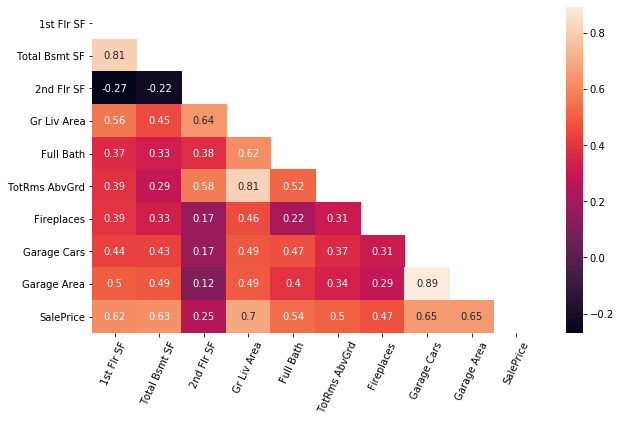

In [317]:
#creating heatmap with above features of interest based on pairplot
heatmap(['1st Flr SF','Total Bsmt SF','2nd Flr SF','Gr Liv Area',
         'Full Bath','TotRms AbvGrd','Fireplaces','Garage Cars','Garage Area','SalePrice'],df)

Terms for Feature Interaction in Next Model: `1st Flr SF*Total Bsmt SF`,`Gr Liv Area*TotRms AbvGrd`,`Garage Area*Garage Cars`

In [182]:
#creating df to make sure x and y are same size
first = df[['1st Flr SF','Total Bsmt SF','2nd Flr SF','Gr Liv Area',
         'Full Bath','TotRms AbvGrd','Fireplaces','Garage Cars','Garage Area','SalePrice']]
first.dropna(inplace=True)
first.shape

/Users/natimarcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(2049, 10)

In [183]:
X1 = first.drop(columns='SalePrice')
y = first['SalePrice']

In [189]:
#scaled regression with no regularization
regression(X1,y,scale=True)

{'cv_score_sc': 0.7209593267817588,
 'train_score_sc': 0.7275161167899351,
 'test_score_sc': 0.6002986494408097,
 'rmse_sc': 41838.4517685344}

In [187]:
#scaled regression with ridge regularization
regression(X1,y,scale=True,ridge=True)

{'rcv_best_score_sc': 0.721017314058968,
 'r_cv_score_sc': 0.7158870867468053,
 'r_train_score_sc': 0.7269050180678337,
 'r_test_score_sc': 0.6040008853509418,
 'r_rmse_sc': 41885.34097380862,
 'rcv_rmse_sc': 209710.2210909808}

In [188]:
#scaled regression with lassoCV regularization
regression(X1,y,scale=True,lasso=True)

{'lassoCV_train_score_sc': 0.7275160167858793,
 'lassoCV_test_score_sc': 0.6003320430255887,
 'lassoCV_rmse_sc': 41838.45944607927}

In [203]:
#checking 75% train set to see if any major descrepancies with test set
first.iloc[:1538].agg(['mean','median','min','max'])

,1st Flr SF,Total Bsmt SF,2nd Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,SalePrice
mean,1163.778934,1051.990897,318.122887,1487.342653,1.559818,6.405072,0.577373,1.763329,470.269181,179662.223667
median,1092.500000,991.500000,0.000000,1433.500000,2.000000,6.000000,0.000000,2.000000,480.000000,160000.000000
min,334.000000,0.000000,0.000000,334.000000,0.000000,2.000000,0.000000,0.000000,0.000000,13100.000000
max,4692.000000,6110.000000,1862.000000,5642.000000,3.000000,14.000000,4.000000,5.000000,1418.000000,556581.000000


In [204]:
#test set checking
first.iloc[-512:].agg(['mean','median','min','max'])

,1st Flr SF,Total Bsmt SF,2nd Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,SalePrice
mean,1167.402344,1076.240234,361.904297,1535.046875,1.628906,6.533203,0.632812,1.818359,484.205078,187093.650391
median,1093.500000,1008.000000,0.000000,1478.500000,2.000000,6.000000,1.000000,2.000000,483.000000,170000.000000
min,483.000000,0.000000,0.000000,492.000000,0.000000,3.000000,0.000000,0.000000,0.000000,12789.000000
max,5095.000000,5095.000000,1836.000000,5095.000000,4.000000,15.000000,3.000000,4.000000,1231.000000,611657.000000


In [209]:
#OLS_sum(X1,y)

## Model 2 (Using Interaction Terms)

[Back to Top](#Sections)

In [207]:
#feature interactions:
#1st Flr SF*Total Bsmt SF,Gr Liv Area*TotRms AbvGrd,Garage Area*Garage Cars
df['1st Flr SF*Total Bsmt SF'] = df['1st Flr SF']*df['Total Bsmt SF']
df['Garage Area*Garage Cars'] = df['Garage Area']*df['Garage Cars']

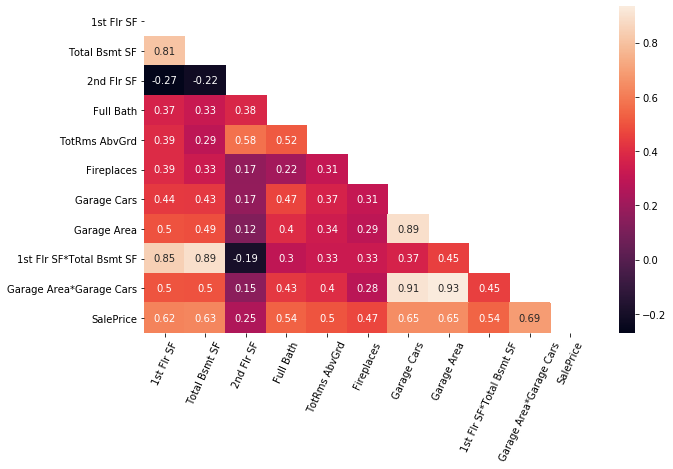

In [318]:
#creating heatmap of new features, which are model 1 features and new feature interactions
heatmap(['1st Flr SF','Total Bsmt SF','2nd Flr SF',
         'Full Bath','TotRms AbvGrd','Fireplaces','Garage Cars','Garage Area',
         '1st Flr SF*Total Bsmt SF','Garage Area*Garage Cars','SalePrice'],df)

In [211]:
#creating df to ensure same size of x and y
second = df[['1st Flr SF','Total Bsmt SF','2nd Flr SF',
         'Full Bath','TotRms AbvGrd','Fireplaces','Garage Cars','Garage Area',
         '1st Flr SF*Total Bsmt SF','Garage Area*Garage Cars','SalePrice']]
second.dropna(inplace=True)
second.shape

/Users/natimarcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(2049, 11)

In [212]:
X2 = second.drop(columns=['SalePrice'])
y = second['SalePrice']

In [214]:
#scaled, no regularization
regression(X2,y,scale=True)

{'cv_score_sc': 0.6693810201370206,
 'train_score_sc': 0.7442235885116144,
 'test_score_sc': 0.6867618780451255,
 'rmse_sc': 40535.49120772774}

In [216]:
#scaled, ridge
regression(X2,y,scale=True,ridge=True)

{'rcv_best_score_sc': 0.6693605539053005,
 'r_cv_score_sc': 0.6200022533368611,
 'r_train_score_sc': 0.7442204379947222,
 'r_test_score_sc': 0.6860853814779175,
 'r_rmse_sc': 40535.740854197844,
 'rcv_rmse_sc': 204958.12684801721}

In [217]:
#scaled, lassoCV
regression(X2,y,scale=True,lasso=True)

{'lassoCV_train_score_sc': 0.7442235716984843,
 'lassoCV_test_score_sc': 0.6867191802869108,
 'lassoCV_rmse_sc': 40535.49254000164}

## Model 3 (Adding Polynomial Features)

[Back to Top](#Sections)

In [218]:
#getting rid of feature interactions so that poly transformation can be conducted
third = first

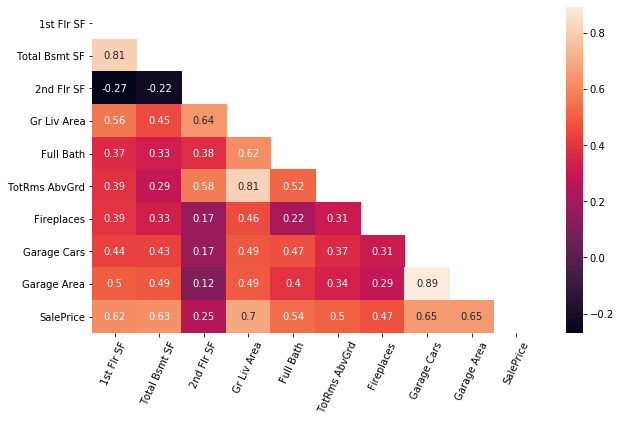

In [320]:
heatmap(third.columns,df)

In [220]:
X3 = third.drop(columns='SalePrice')
y = third['SalePrice']

In [221]:
#creating poly transformation for features
poly = PolynomialFeatures(include_bias=False)
X3_poly = poly.fit_transform(X3)

In [222]:
#scaled regression with no regularization
regression(X3_poly,y,scale=True)

{'cv_score_sc': 0.659098291000002,
 'train_score_sc': 0.8070871197537695,
 'test_score_sc': 0.6096133156217208,
 'rmse_sc': 35203.497061929374}

In [223]:
#scaled regression with ridge regularization
regression(X3_poly,y,scale=True,ridge=True)

{'rcv_best_score_sc': 0.6865523642333048,
 'r_cv_score_sc': 0.31249793460627584,
 'r_train_score_sc': 0.36005219065800964,
 'r_test_score_sc': 0.34432743574644964,
 'r_rmse_sc': 64117.631847691286,
 'rcv_rmse_sc': 190899.31399086883}

In [234]:
#OLS_sum(X3_poly,y,scale=True)

In [232]:
#making list of tuples and df names for poly features df in order to find which to eliminate from OLS summary p-val
names = list(pd.DataFrame(X3_poly,columns=poly.get_feature_names(X3.columns)).columns)
col_nums = [(names[i],i+1) for i in range(len(names))]
col_nums[:5]

[('1st Flr SF', 1),
 ('Total Bsmt SF', 2),
 ('2nd Flr SF', 3),
 ('Gr Liv Area', 4),
 ('Full Bath', 5)]

## Model 4 (Dropping Insignficant Poly Features)

[Back to Top](#Sections)

In [244]:
#dropping insignificant columns for future iteration of model
drops = [1,2,3,4,5,6,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,
         38,39,41,43,44,45,47,48,50,51,52,53,54]
signif = [tup[0] for tup in col_nums if tup[1] not in drops]
signif

['Fireplaces',
 'Garage Cars',
 'Total Bsmt SF^2',
 'Full Bath^2',
 'Full Bath Fireplaces',
 'TotRms AbvGrd Fireplaces',
 'Fireplaces^2']

In [324]:
#creating new poly features for next model
fourth = df[['Fireplaces','Garage Cars','Total Bsmt SF','Full Bath','TotRms AbvGrd','SalePrice']]
#manually creating above poly features
fourth['Total Bsmt SF^2'] = fourth['Total Bsmt SF']*fourth['Total Bsmt SF']
fourth['Full Bath^2'] = fourth['Full Bath']*fourth['Full Bath']
fourth['Full Bath Fireplaces'] = fourth['Full Bath']*fourth['Fireplaces']
fourth['TotRms AbvGrd Fireplaces'] = fourth['TotRms AbvGrd']*fourth['Fireplaces']
fourth['Fireplaces^2'] = fourth['Fireplaces']*fourth['Fireplaces']
#dropping null to makesure x,y same size
fourth.dropna(inplace=True)
X4 = fourth.drop(columns='SalePrice')
y = fourth['SalePrice']

/Users/natimarcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/natimarcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/natimarcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a c

In [307]:
#scaled regression with no regularization
regression(X4,y,scale=True)

{'cv_score_sc': 0.6147469330888822,
 'train_score_sc': 0.6923499376632081,
 'test_score_sc': 0.6320935533507123,
 'rmse_sc': 44456.33934698015}

In [309]:
#scaled regression with ridge regularization
regression(X4,y,scale=True,ridge=True)

{'rcv_best_score_sc': 0.6184504490999375,
 'r_cv_score_sc': 0.629243478747121,
 'r_train_score_sc': 0.6887936753981704,
 'r_test_score_sc': 0.5987458535707817,
 'r_rmse_sc': 44712.546253561464,
 'rcv_rmse_sc': 194282.65201418733}

In [310]:
#scaled regression with lassoCV regularization
regression(X4,y,scale=True,lasso=True)

{'lassoCV_train_score_sc': 0.692349919939128,
 'lassoCV_test_score_sc': 0.6320403658507892,
 'lassoCV_rmse_sc': 44456.340627571}

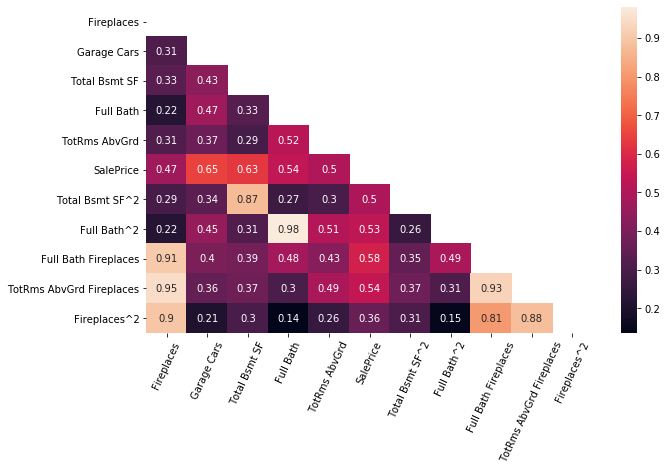

In [326]:
#creating heatmap with polynomial features
heatmap(fourth.columns,fourth)

## Model 5 (Trying Model with Dummy Variables)

[Back to Top](#Sections)

In [ ]:
#Other features of interest:
#MSZoning, Utilities, Neighborhood, BldgType, OverallQual, OverCond, ExterQual,
#ExterCond, BsmtCond, Heating, HeatingQC, CentralAir

In [338]:
#excluding polynomial features from previous model and creating new ones. also adding dummy variables
numerical = df[['1st Flr SF','Total Bsmt SF','2nd Flr SF','Gr Liv Area',
         'Full Bath','TotRms AbvGrd','Fireplaces','Garage Cars','Garage Area']]
numerical.dropna(inplace=True)
poly = PolynomialFeatures(include_bias=False)
X5_poly = poly.fit_transform(numerical)
X5_poly_df = pd.DataFrame(X5_poly,columns=poly.get_feature_names(numerical.columns))
features = df[['MS Zoning','Utilities','Neighborhood','Bldg Type',
              'Overall Qual','Overall Cond','Exter Qual','Exter Cond','Bsmt Cond',
              'Heating','Heating QC','Central Air']]
X5_total = pd.concat([X5_poly_df, features,df['SalePrice']], axis=1)
fifth = pd.get_dummies(columns=features.columns,
                     drop_first=True,data=X5_total)
fifth.dropna(inplace=True)
X5 = fifth.drop(columns='SalePrice')
y = fifth['SalePrice']

/Users/natimarcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [341]:
#scaled regression with no regularization
regression(X5,y,scale=True)

{'cv_score_sc': 0.6989478540224544,
 'train_score_sc': 0.8384238989888679,
 'test_score_sc': 0.724890820556573,
 'rmse_sc': 31752.32973307279}

In [343]:
#scaled regression with ridge regularization
regression(X5,y,scale=True,ridge=True)

/Users/natimarcus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.04197e-17): result may not be accurate.
  overwrite_a=True).T
/Users/natimarcus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.8565e-17): result may not be accurate.
  overwrite_a=True).T
/Users/natimarcus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.12508e-17): result may not be accurate.
  overwrite_a=True).T
/Users/natimarcus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.28049e-17): result may not be accurate.
  overwrite_a=True).T
/Users/natimarcus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.12723e-17): result may not be accurate.
  overwrite_a=True

{'rcv_best_score_sc': 0.7191977325190374,
 'r_cv_score_sc': 0.7715766766453336,
 'r_train_score_sc': 0.8366011058842191,
 'r_test_score_sc': 0.7658875530173399,
 'r_rmse_sc': 31930.93166325827,
 'rcv_rmse_sc': 228944.67078296855}

## Model 6

[Back to Top](#Sections)

In [364]:
# insignificant dummies to drop:
drops1 = ['MS Zoning_I (all)', 'Utilities_NoSeWa', 'Utilities_NoSewr', 'Neighborhood_Blueste',
'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_Greens','Neighborhood_Landmrk',
 'Neighborhood_MeadowV', 'Neighborhood_NPkVill', 'Neighborhood_NridgHt', 'Neighborhood_Veenker', 
 'Bldg Type_2fmCon', 'Bldg Type_Duplex', 'Overall Qual_2', 'Overall Qual_3', 'Overall Qual_4', 
 'Overall Qual_5', 'Overall Qual_6', 'Overall Qual_7', 'Overall Cond_3', 'Exter Cond_Fa',
 'Exter Cond_Gd', 'Exter Cond_Po', 'Exter Cond_TA', 'Bsmt Cond_Fa', 'Bsmt Cond_Po', 'Heating_GasW',
 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'Heating QC_Fa', 'Heating QC_Gd', 'Heating QC_Po']

In [368]:
X6 = fifth.drop(columns=drops1+['SalePrice'])

In [369]:
#scaled regression with no regularization
regression(X6,y,scale=True)

{'cv_score_sc': 0.6528908637394913,
 'train_score_sc': 0.8120767517327158,
 'test_score_sc': 0.6956925729333294,
 'rmse_sc': 34243.43235182643}

In [370]:
#scaled regression with ridge regularization
regression(X6,y,scale=True,ridge=True)

/Users/natimarcus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.21957e-17): result may not be accurate.
  overwrite_a=True).T
/Users/natimarcus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=5.11469e-17): result may not be accurate.
  overwrite_a=True).T
/Users/natimarcus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.12508e-17): result may not be accurate.
  overwrite_a=True).T
/Users/natimarcus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.7505e-17): result may not be accurate.
  overwrite_a=True).T
/Users/natimarcus/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.17249e-17): result may not be accurate.
  overwrite_a=True

{'rcv_best_score_sc': 0.6396313915376104,
 'r_cv_score_sc': 0.746266398082864,
 'r_train_score_sc': 0.8108003506480659,
 'r_test_score_sc': 0.7381200430667549,
 'r_rmse_sc': 34359.528649821936,
 'rcv_rmse_sc': 234636.2893051624}

## Running Model 5 On Test Data
[Back to Top](#Sections)

In [371]:
#loading in test data
test_data = pd.read_csv('datasets/test.csv')
test_data.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [414]:
#Model 5
numerical = df[['1st Flr SF','Total Bsmt SF','2nd Flr SF','Gr Liv Area',
         'Full Bath','TotRms AbvGrd','Fireplaces','Garage Cars','Garage Area']]
numerical.dropna(inplace=True)
poly = PolynomialFeatures(include_bias=False)
X5_poly = poly.fit_transform(numerical)
X5_poly_df = pd.DataFrame(X5_poly,columns=poly.get_feature_names(numerical.columns))
features = df[['MS Zoning','Utilities','Neighborhood','Bldg Type',
              'Overall Qual','Overall Cond','Exter Qual','Exter Cond','Bsmt Cond',
              'Heating','Heating QC','Central Air']]
X5_total = pd.concat([X5_poly_df, features,df['SalePrice']], axis=1)
fifth = pd.get_dummies(columns=features.columns,
                     drop_first=True,data=X5_total)
fifth.dropna(inplace=True)
X5 = fifth.drop(columns='SalePrice')
y = fifth['SalePrice']

/Users/natimarcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [415]:
#Model 5 - Test Data
numerical_test = test_data[['1st Flr SF','Total Bsmt SF','2nd Flr SF','Gr Liv Area',
         'Full Bath','TotRms AbvGrd','Fireplaces','Garage Cars','Garage Area']]
numerical_test.dropna(inplace=True)
poly_test = PolynomialFeatures(include_bias=False)
X5_poly_test = poly_test.fit_transform(numerical_test)
X5_poly_test_df = pd.DataFrame(X5_poly_test,columns=poly_test.get_feature_names(numerical_test.columns))
features_test = test_data[['MS Zoning','Utilities','Neighborhood','Bldg Type',
              'Overall Qual','Overall Cond','Exter Qual','Exter Cond','Bsmt Cond',
              'Heating','Heating QC','Central Air']]
X5_total_test = pd.concat([X5_poly_test_df, features_test], axis=1)
fifth_test = pd.get_dummies(columns=features_test.columns,
                     drop_first=True,data=X5_total_test)
fifth_test.dropna(inplace=True)
X5_test = fifth_test

/Users/natimarcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [407]:
#checking to see which dummy columns are not included in both df
for i in list(X5_test.columns):
    if i not in list(X5.columns):
        print(i)

Heating_GasA


In [408]:
#checking to see which dummy columns are not included in both df
for i in list(X5.columns):
    if i not in list(X5_test.columns):
        print(i)

MS Zoning_C (all)
Utilities_NoSeWa
Neighborhood_GrnHill
Neighborhood_Landmrk
Overall Qual_2
Bsmt Cond_Fa
Bsmt Cond_Po
Heating_OthW
Heating_Wall
Heating QC_Po


In [416]:
#dropping dummies above and scaling X data to predict y for test data
X5_test.drop(columns=['Heating_GasA'],inplace=True)
X5.drop(columns=['MS Zoning_C (all)','Utilities_NoSeWa','Neighborhood_GrnHill','Neighborhood_Landmrk',
                 'Overall Qual_2','Bsmt Cond_Fa','Bsmt Cond_Po','Heating_OthW','Heating_Wall','Heating QC_Po'],
       inplace=True)

sc = StandardScaler()
X5_sc = sc.fit_transform(X5)
X5_test_sc = sc.transform(X5_test)
lr = LinearRegression()
lr.fit(X5_sc,y)
y_test = lr.predict(X5_test_sc)

In [417]:
y_test.shape

(878,)

In [425]:
#creating df for submission
test_df = pd.concat([test_data['Id'],pd.Series(y_test)],keys=['Id','SalePrice'],axis=1)
test_df.head()

,Id,SalePrice
0,2658,126699.130513
1,2718,144516.230662
2,2414,200304.676670
3,1989,121277.478051
4,625,173924.997018


In [426]:
#checking shape
test_df.shape

(878, 2)

In [427]:
#submission csv
test_df.to_csv('submission_1.csv')